In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from functools import partial
from jax_tqdm import scan_tqdm

from algorithms.utils import restore_state

import numpy as np

2025-02-25 10:38:42.940304: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1740476322.952736   45366 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1740476322.956627   45366 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.single_agent.env import MicroGridEnv
from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    if env_type == 'normal':
        env = MicroGridEnv(params, battery_type)
    elif env_type == 'soc_action':
        env = MicroGridEnvSocAction(params, battery_type)
    else:
        raise ValueError('Unknown env_type')
    return env, env.params

In [5]:
from ernestogym.envs_jax.single_agent.utils import parameter_generator

# Testing

In [6]:
@partial(jax.jit, static_argnums=(0, 2, 3))
def test(env: MicroGridEnv, env_params, network, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, env_params)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv, env_state, rng = runner_state

        pi, _ = network(obsv)

        #deterministic action
        action = pi.mode()

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward, done, info = env.step(_rng, env_state, action, env_params)

        runner_state = (obsv, env_state, rng)
        return runner_state, (info, action)

    runner_state = (obsv, env_state, rng)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [7]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/single_agent/ijcnn_deg_test.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

params['step']

3600

In [8]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250225_103553_lr_0.0005_tot_timesteps_3504000_anneal_rl_True_normal'

network, config, params_training = restore_state(directory)
env_type = config['ENV_TYPE']

In [9]:
env, env_params = my_env_creator(params, battery_type, env_type=env_type)
env_params = env.eval(env_params)

In [10]:
num_iter = 8760 * 8
info, actions = test(env, env_params, network, num_iter, jax.random.PRNGKey(51))


Running for 70,080 iterations:   0%|          | 0/70080 [00:00<?, ?it/s]

In [11]:
jax.tree.map(lambda val: val.shape, info)

{'buy_price': (70080,),
 'demand': (70080,),
 'generation': (70080,),
 'i_to_apply': (70080,),
 'norm_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'p': (70080,),
 'pure_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)},
 'r_tot': (70080,),
 'sell_price': (70080,),
 'soc': (70080,),
 'soh': (70080,),
 'weig_reward': {'r_clipping': (70080,),
  'r_deg': (70080,),
  'r_op': (70080,),
  'r_trad': (70080,)}}

In [12]:
actions.max(), actions.min(), actions.mean()

(Array(0.4960583, dtype=float32),
 Array(-1.1733056, dtype=float32),
 Array(-0.07094049, dtype=float32))

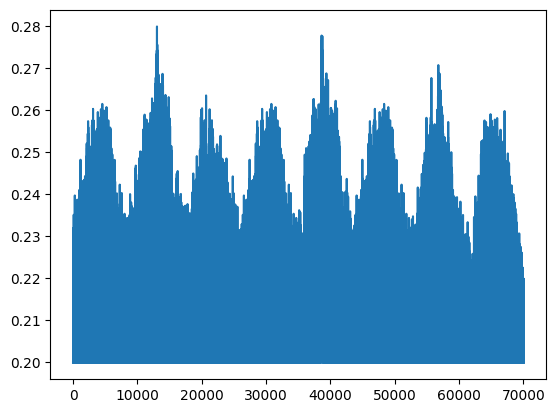

In [13]:
plt.plot(info['soc'])

In [14]:
reward_type = 'weig_reward'

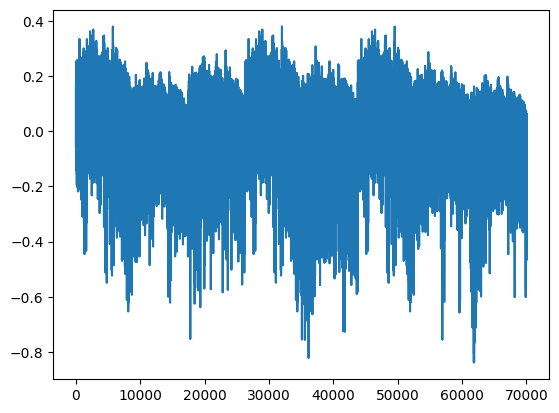

In [15]:
plt.plot(info[reward_type]['r_trad'])

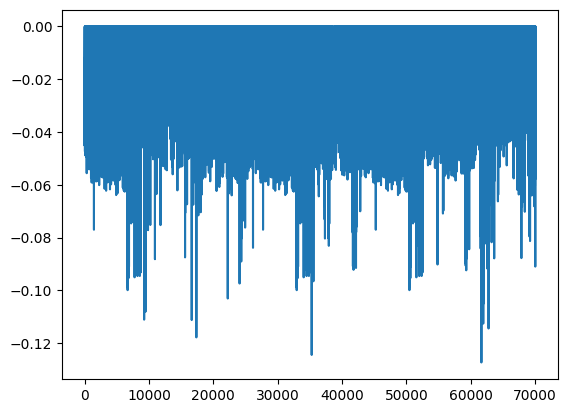

In [16]:
plt.plot(info[reward_type]['r_clipping'])

In [17]:
info['pure_reward']['r_clipping'].mean(), info['weig_reward']['r_clipping'].mean()

(Array(-24.584503, dtype=float32), Array(-0.0102287, dtype=float32))

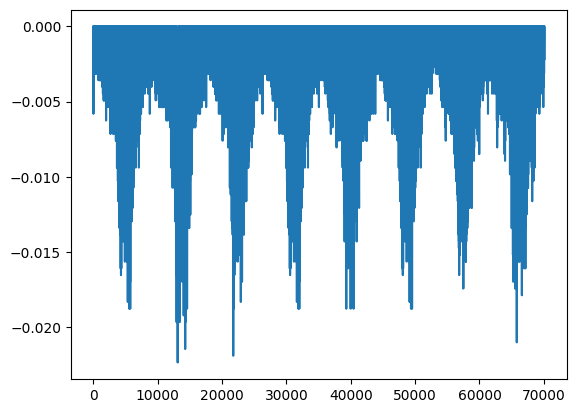

In [18]:
plt.plot(info[reward_type]['r_deg'])

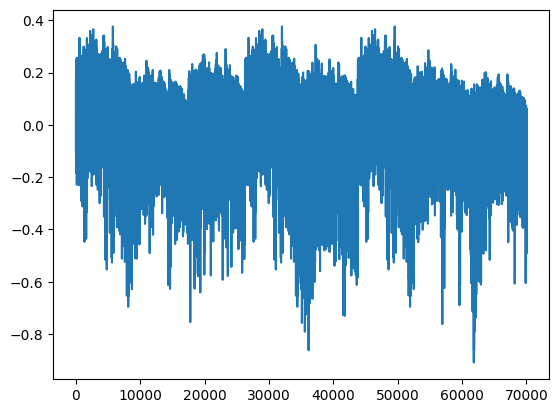

In [19]:
plt.plot(info['r_tot'])

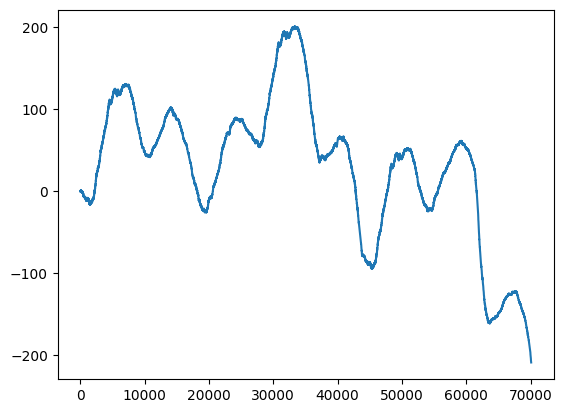

In [20]:
plt.plot(np.cumsum(info[reward_type]['r_trad']))

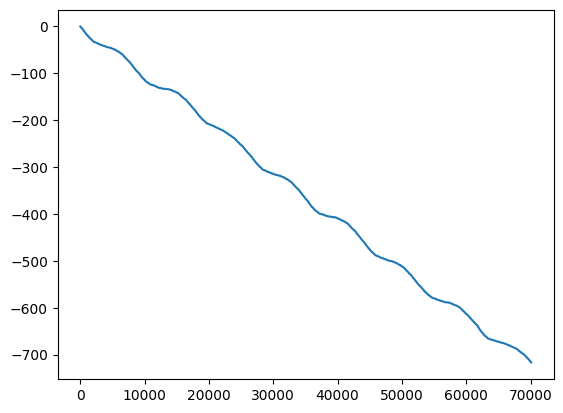

In [21]:
plt.plot(np.cumsum(info[reward_type]['r_clipping']))

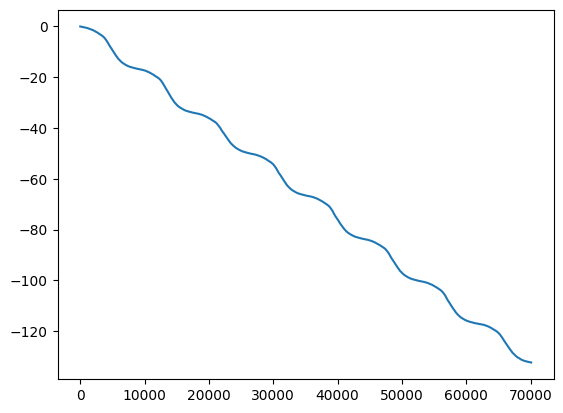

In [22]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

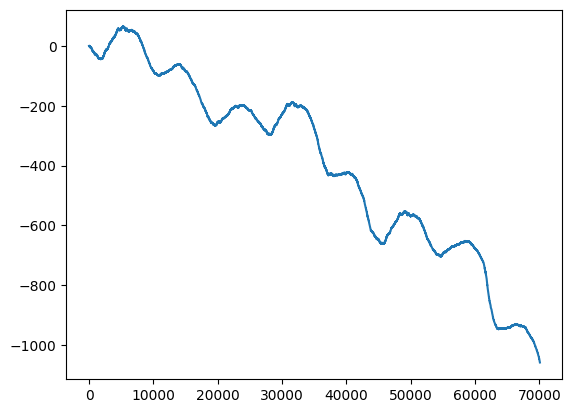

In [23]:
plt.plot(np.cumsum(info['r_tot']))

In [24]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]


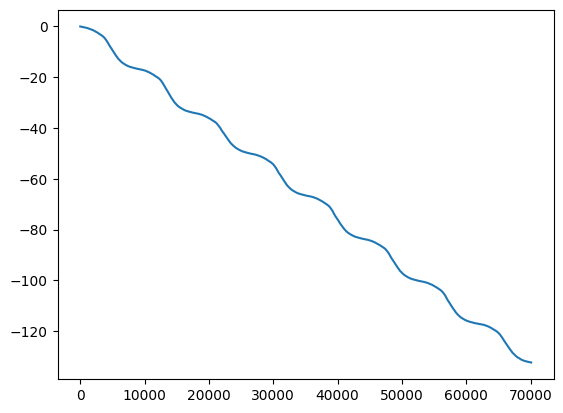

In [25]:
plt.plot(np.cumsum(info[reward_type]['r_deg']))

In [26]:
print(info['soc'])

[0.2 0.2 0.2 ... 0.2 0.2 0.2]
